In [794]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Exploratory Data Analysis

In [795]:
df = pd.read_csv('Titanic-Dataset.csv')

# print(df['Embarked'])
# print(df.describe())
# print(df.info())

##shows there is null values
# Check for missing values in each column
print(df.isnull().sum())
df

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Age contains missing values, so does the cabin class.  Due to the exceessibe number of null values these  need to be removed

In [796]:
#impute values of age with median
df['Age'].fillna(df['Age'].median(), inplace=True)

#drop cabin column, name and ticjet
df.drop(columns=['Cabin', 'Ticket', 'Name'], inplace=True)

#impute embarked with the mode
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

#convert age to binary values
df['Sex'] = df['Sex'].map({'male': 0, 'female':1})



#rename column so easier to understand
df.rename(columns={'Pclass': 'PassengerClass', 'Parch': 'ParentsChildrenAboard', 'SibSp':'SiblingsSpouses'}, inplace=True)

df.columns


Index(['PassengerId', 'Survived', 'PassengerClass', 'Sex', 'Age',
       'SiblingsSpouses', 'ParentsChildrenAboard', 'Fare', 'Embarked'],
      dtype='object')

View distribution of 'survival variable'

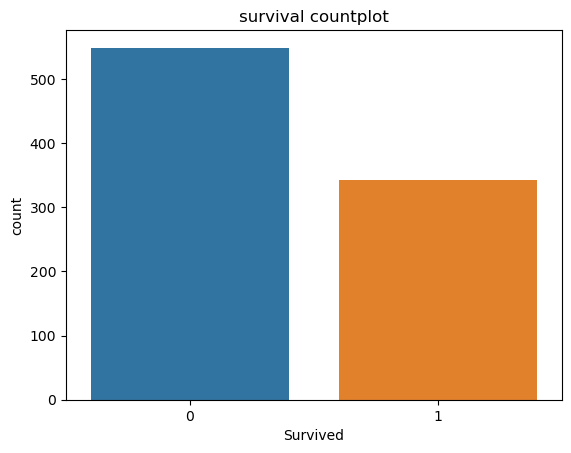

In [797]:
sns.countplot(x='Survived', data=df)
plt.title('survival countplot')
plt.show()

Visulise relationships

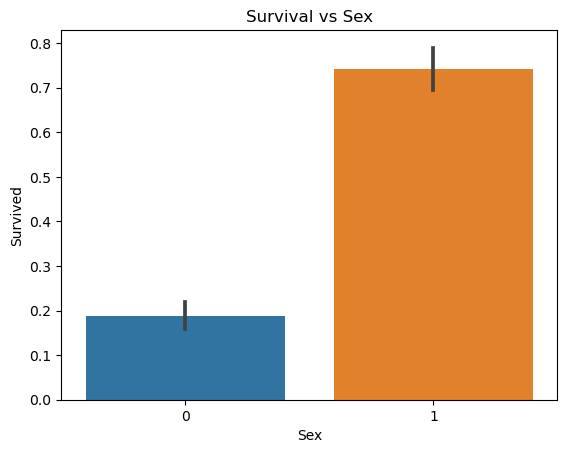

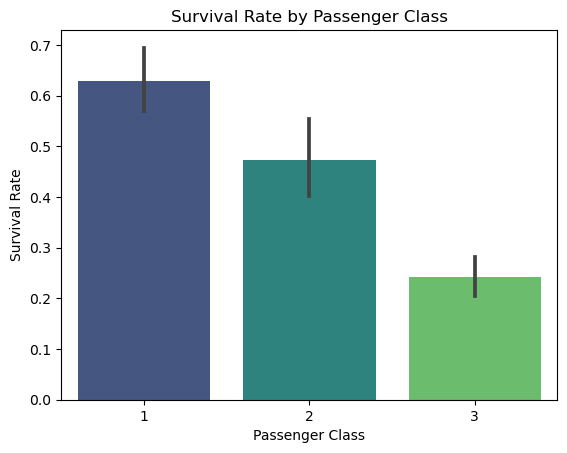

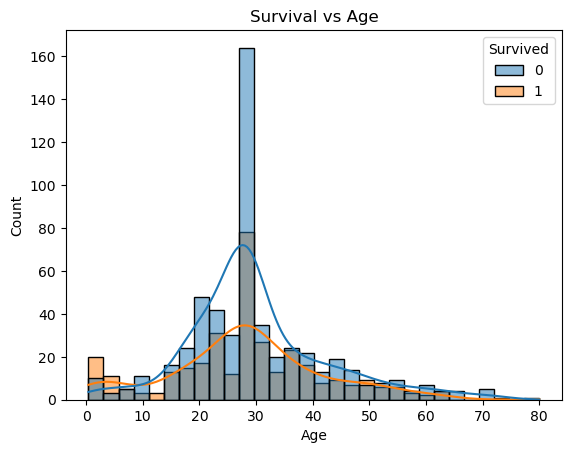

Index(['PassengerId', 'Survived', 'Sex', 'Age', 'SiblingsSpouses',
       'ParentsChildrenAboard', 'Fare', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'PassengerClass_1', 'PassengerClass_2',
       'PassengerClass_3'],
      dtype='object')

In [798]:
#Survival rate by gender
sns.barplot(x = 'Sex', y = 'Survived', data=df)
plt.title('Survival vs Sex')
plt.show()

# Plot survival rates by Pclass
sns.barplot(x='PassengerClass', y='Survived', data=df, palette='viridis')
plt.title('Survival Rate by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')
plt.show()

#Survival rate by Age
sns.histplot(x = 'Age', hue = 'Survived', data=df,kde=True,bins=30)
plt.title('Survival vs Age')
plt.show()

# Apply one-hot encoding to 'Embarked' and 'Pclass'
df = pd.get_dummies(df, columns=['Embarked', 'PassengerClass'])

df.columns

Check Correlations for numerical features eg how fare and age affected survival

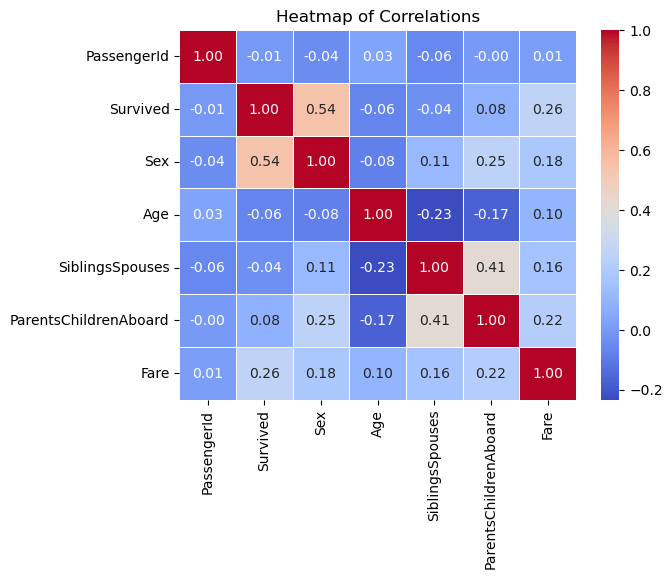

In [799]:
#remove non-numeric colums

numeric_df = df.select_dtypes(include=[np.number])



corr_matrix = numeric_df.corr()
# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap of Correlations')
plt.show()

look for outliers in data usingg boxplots

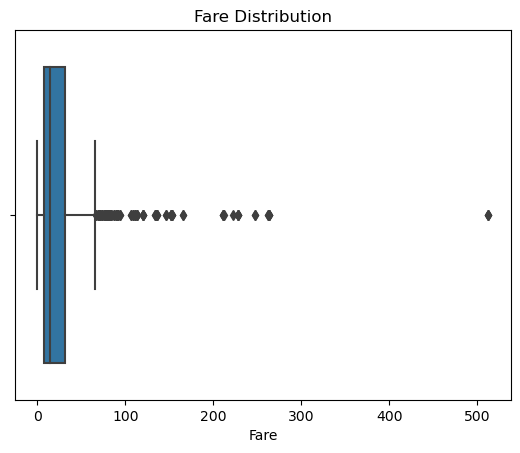

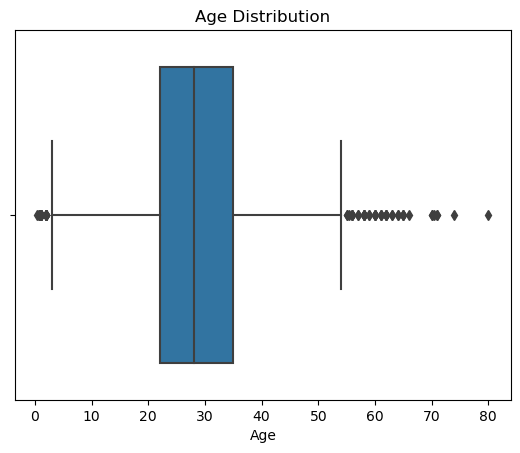

In [800]:
sns.boxplot(x = df['Fare'])
plt.title('Fare Distribution')
plt.show()

sns.boxplot(x = df['Age'])
plt.title('Age Distribution')
plt.show()

# Creation of Data for model

In [801]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [802]:
#remove featuires that have little correlation to survival chance

X = df.drop(columns = ['Survived', 'PassengerId'])
y = df['Survived']

print(X.shape)
print(y.shape)

#scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

(891, 11)
(891,)


In [803]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

#convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)




# Create Model 

In [804]:
class LogisticClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LogisticClassifier, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, 64)
        self.layer3 = nn.Linear(64, 12)
        self.layer4 = nn.Linear(12, output_size)
        self.relu = nn.ReLU()

    def forward(self,x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x =  self.relu(x)
        x = self.layer3(x)
        x =  self.relu(x)
        x = self.layer4(x)

        return x

input_size = X_train.shape[1]
hidden_size = 128
output_size = 1

In [805]:
#Create instance of model
model = LogisticClassifier(input_size, hidden_size,output_size).to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()


# Create Training Loop

In [806]:
num_epochs = 10000

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)


    #backpropogation
    loss.backward()
    optimiser.step()
    optimiser.zero_grad()

    #print the loss and accuracy every 10 epochs

    if (epoch + 1)%100 == 0:
        print(f'epoch {epoch+1}, loss = {loss.item(): .2f}')

epoch 100, loss =  0.37
epoch 200, loss =  0.31
epoch 300, loss =  0.26
epoch 400, loss =  0.24
epoch 500, loss =  0.22
epoch 600, loss =  0.21
epoch 700, loss =  0.20
epoch 800, loss =  0.19
epoch 900, loss =  0.19
epoch 1000, loss =  0.18
epoch 1100, loss =  0.18
epoch 1200, loss =  0.17
epoch 1300, loss =  0.17
epoch 1400, loss =  0.16
epoch 1500, loss =  0.16
epoch 1600, loss =  0.16
epoch 1700, loss =  0.16
epoch 1800, loss =  0.15
epoch 1900, loss =  0.15
epoch 2000, loss =  0.15
epoch 2100, loss =  0.15
epoch 2200, loss =  0.14
epoch 2300, loss =  0.14
epoch 2400, loss =  0.14
epoch 2500, loss =  0.14
epoch 2600, loss =  0.14
epoch 2700, loss =  0.14
epoch 2800, loss =  0.13
epoch 2900, loss =  0.14
epoch 3000, loss =  0.13
epoch 3100, loss =  0.13
epoch 3200, loss =  0.13
epoch 3300, loss =  0.13
epoch 3400, loss =  0.13
epoch 3500, loss =  0.13
epoch 3600, loss =  0.12
epoch 3700, loss =  0.13
epoch 3800, loss =  0.13
epoch 3900, loss =  0.12
epoch 4000, loss =  0.12
epoch 410

# Evaluate model
1. Compare y_test and y_pred using .eq ie [True, true , false]
2. use .sum() to get the number of correct predictions
3. get the total number of predcitions using y_test.shape[0]
4. extract scalar value using .item()

In [807]:
model.eval()

with torch.no_grad():
    y_pred = model(X_test)
    y_pred = torch.sigmoid(y_pred) # sqaush values to get probablities
    y_pred = y_pred.round() #convert to binary values

    accuracy = (y_pred.eq(y_test).sum() / float(y_test.shape[0])).item()

    print(f'accuracy: {accuracy:4f}')

accuracy: 0.826816
